In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib
import utils.serviceArea
importlib.reload(utils.serviceArea)
import utils.serviceArea as serviceArea
from bs4 import BeautifulSoup 

# Import driving network

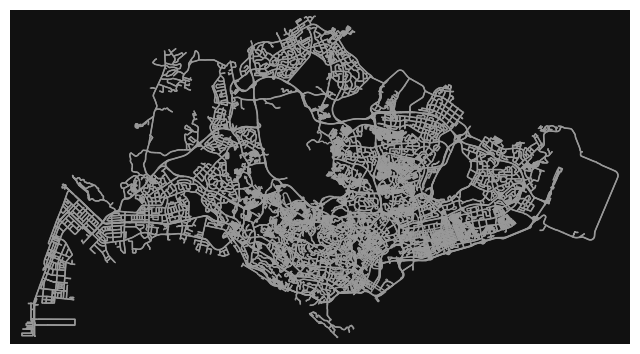

In [2]:
G_car = ox.load_graphml(r"data\SG_car_network.graphml")
nodes = ox.graph_to_gdfs(G_car, nodes=True, edges=False)
edges = ox.graph_to_gdfs(G_car, nodes=False, edges=True)
fig, ax = ox.plot_graph(G_car, node_size=0)

- Check if maxspeed has any null/NA values

In [16]:
print("Does maxspeed have no NA/null values? ",pd.to_numeric(edges['maxspeed'], errors='coerce').notna().all())
print("Does speed_kph have no NA/null values? ",pd.to_numeric(edges['speed_kph'], errors='coerce').notna().all())
print("Does travel_time have no NA/null values? ",pd.to_numeric(edges['travel_time'], errors='coerce').notna().all())

Does maxspeed have no NA/null values?  True
Does speed_kph have no NA/null values?  True
Does travel_time have no NA/null values?  True


### Import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


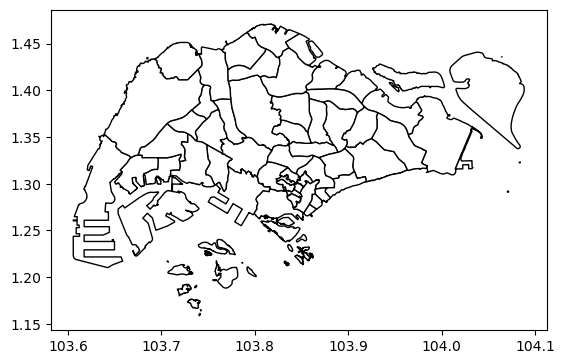

In [6]:
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

### Import subzone

,Name,Descriptio,SUBZONE_NO,SUBZONE_N,SUBZONE_C,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,12,DEPOT ROAD,BMSZ12,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,2,BUKIT MERAH,BMSZ02,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,3,CHINATOWN,OTSZ03,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,4,PHILLIP,DTSZ04,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,5,RAFFLES PLACE,DTSZ05,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2..."


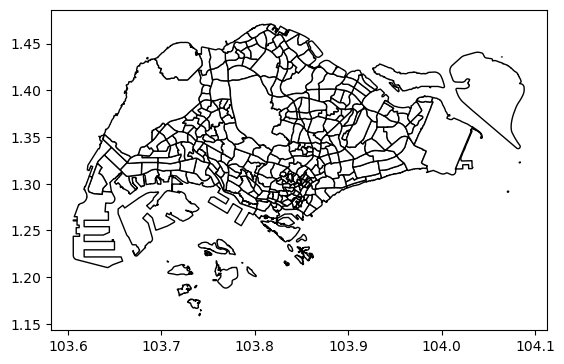

In [7]:
subzone_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019SubzoneBoundaryNoSeaGEOJSON.shp")
subzone_shp.plot(fc='white',ec='k')
subzone_shp.head()

### Import hospital coordinates

In [4]:
hospitals = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Hospitals and clinics\publichospitaltraumaunit_with_coordinates.csv")
hospitals = hospitals.rename(columns={"easting":"lon","northing":"lat"})
hospitals.loc[3,"lon"] = 103.78314#103.78300
hospitals.loc[3,"lat"] = 1.29372#1.29293
hospitals["node_ID"] = ox.nearest_nodes(G_car, X=hospitals["lon"], Y=hospitals["lat"])

hospitals

,name,address,postal_code,lon,lat,Unnamed: 5,node_ID
0,CHANGI GENERAL HOSPITAL,2 SIMEI STREET 3 Singapore 529889,529889,103.949421,1.340695,Y,11380947541
1,KHOO TECK PUAT HOSPITAL,90 YISHUN CENTRAL Singapore 768828,768828,103.838408,1.423865,Y,244908016
2,KK WOMEN'S AND CHILDREN'S HOSPITAL,100 BUKIT TIMAH ROAD Singapore 229899,229899,103.846650,1.310449,Y,74353691
3,NATIONAL UNIVERSITY HOSPITAL,5 LOWER KENT RIDGE ROAD Singapore 119074,119074,103.783140,1.293720,Y,496810076
4,NG TENG FONG GENERAL HOSPITAL,1 JURONG EAST STREET 21 Singapore 609606,609606,103.743865,1.335534,Y,3561043163
5,SENGKANG GENERAL HOSPITAL,110 SENGKANG EAST WAY Singapore 544886,544886,103.893001,1.394299,Y,4430972591
6,SINGAPORE GENERAL HOSPITAL,- OUTRAM ROAD Singapore 169608,169608,103.830722,1.279940,Y,5231491934
7,TAN TOCK SENG HOSPITAL,11 JALAN TAN TOCK SENG Singapore 308433,308433,103.849901,1.319500,Y,2440447191


In [29]:
edges.columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref',
       'reversed', 'length', 'bridge', 'geometry', 'speed_kph', 'travel_time',
       'tunnel', 'junction', 'access', 'width'],
      dtype='object')

C:\Users\hypak\AppData\Local\Temp\ipykernel_21536\1958944100.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull


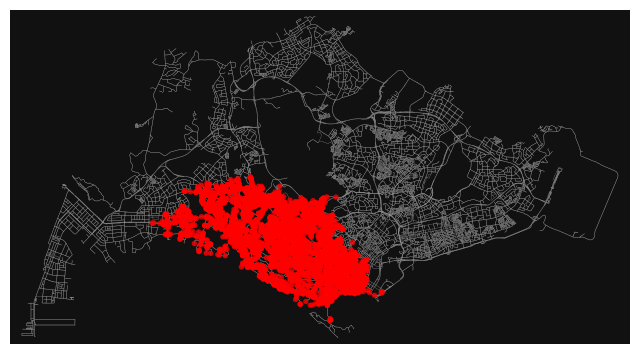

In [ ]:
def get_serviceAreaHospitals(G, hospitals,time=480,color="red",plot=True):
    """ 
    Assumption is that ambulances have to reach hospitals within 8 minutes. Calculate 8 minutes service area from each hospital with trauma units.
    Args:
        G (networkx graph): the networkx graph of the area
        hospitals (pandas dataframe): dataframe containing hospital information including node_ID and hospital coordinates
        time (int): the time in seconds to calculate the service area (default is 480 seconds for 8 minutes)
        color (str): the color to use for the service area polygons (default is "red")
        plot (bool): whether to plot the service area (default is True)
    Returns:
        service_area (geopandas dataframe): dataframe containing the service area polygons for each hospital
    """
    node_colors = dict()
    # make the isochrone polygons
    isochrone_polys = {'hospital':[], 'geometry':[]}
    # select NUH, because it is the only hospital that previously showed werird results i.e. one point
    center_node = hospitals.loc[3,"node_ID"]
    hospital_name = hospitals.loc[3,"name"]
    subgraph = nx.ego_graph(G, center_node, radius=time, distance="travel_time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys["geometry"].append(bounding_poly)
    isochrone_polys["hospital"].append(hospital_name)
    # assign colours to each node within the sub-graph
    for node in subgraph.nodes():
        node_colors[node] = color
    
    if plot:
        nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
        ns = [15 if node in node_colors else 0 for node in G.nodes()]
        fig, ax = ox.plot_graph(
            G,
            node_color=nc,
            node_size=ns,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
        )
        # gdf.plot(column="hospital",alpha=0.5, edgecolor="black", linewidth=0.5, cmap="plasma")
    return 

get_serviceAreaHospitals(G_car, hospitals,time=480,color="red",plot=True)
    

C:\Users\hypak\AppData\Local\Temp\ipykernel_21536\1704654346.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\hypak\AppData\Local\Temp\ipykernel_21536\1704654346.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\hypak\AppData\Local\Temp\ipykernel_21536\1704654346.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\hypak\AppData\Local\Temp\ipykernel_21536\1704654346.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\hypak\AppData\Local\Temp\ipykernel_2153

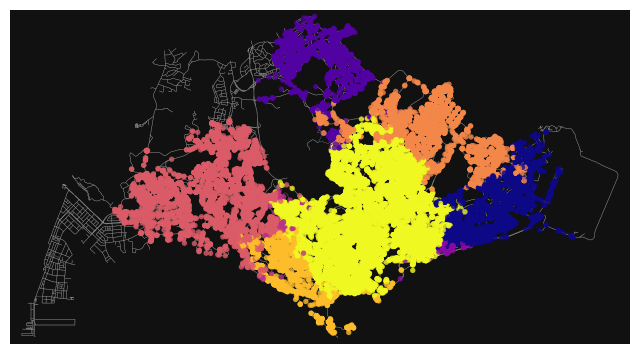

In [ ]:
def get_serviceAreaHospitals(G, hospitals,time=480,color="red",plot=True):
    """ 
    Assumption is that ambulances have to reach hospitals within 8 minutes. Calculate 8 minutes service area from each hospital with trauma units.
    Args:
        G (networkx graph): the networkx graph of the area
        hospitals (pandas dataframe): dataframe containing hospital information including node_ID and hospital coordinates
        time (int): the time in seconds to calculate the service area (default is 480 seconds for 8 minutes)
        color (str): the color to use for the service area polygons (default is "red")
        plot (bool): whether to plot the service area (default is True)
    Returns:
        service_area (geopandas dataframe): dataframe containing the service area polygons for each hospital
    """
    colors = ox.plot.get_colors(n=len(hospitals.index), cmap="plasma", start=0)
    node_colors = dict()
    # make the isochrone polygons
    isochrone_polys = {'hospital':[], 'geometry':[]}
    for i, row in hospitals.iterrows():
        center_node = row["node_ID"]
        hospital_name = row["name"]
        subgraph = nx.ego_graph(G, center_node, radius=time, distance="travel_time")
        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys["geometry"].append(bounding_poly)
        isochrone_polys["hospital"].append(hospital_name)
        # assign colours to each node within the sub-graph
        for node in subgraph.nodes():
            node_colors[node] = colors[i]
    
    gdf = gpd.GeoDataFrame(isochrone_polys, crs="EPSG:4326")
    if plot:
        nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
        ns = [15 if node in node_colors else 0 for node in G.nodes()]
        fig, ax = ox.plot_graph(
            G,
            node_color=nc,
            node_size=ns,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
        )
        # gdf.plot(column="hospital",alpha=0.5, edgecolor="black", linewidth=0.5, cmap="plasma")
    return gdf

serviceAreaHospitals = get_serviceAreaHospitals(G_car, hospitals,time=480,color="red",plot=True)
serviceAreaHospitals
# save service area polygon, note: creation of polygons becomes less accurate when there are too many points in the polygon
# serviceAreaHospitals.to_file(r"data\SG_serviceArea_Hospitals.shp", driver="ESRI Shapefile")
    

<Axes: >

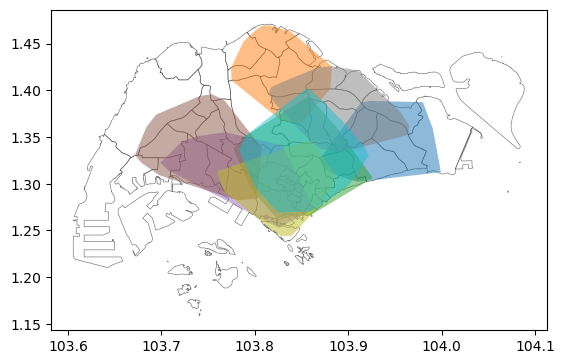

In [50]:
ax = planningArea_shp.plot(fc='white',ec='k', alpha=0.5, edgecolor="black", linewidth=0.5)
serviceAreaHospitals.plot(ax=ax, alpha=0.5, column="hospital")

1. union all polygons
- don't calculate overlapping areas
- calculate service area per planning area

2. Calculate service area for each planning area

In [ ]:
def calculate_serviceArea(serviceArea):
    """ 
    Args:
        serviceArea (gpd): polygon collection in a gdf that represents the union of the service area
    Returns:
        float: Area of service area in km2
    """
    serviceArea = serviceArea.to_crs({'proj':'cea'})
    area = serviceArea.geometry[0].area/10**6 # [0] for index 0, to avoid error, make sure the gdf has 1 item and reset_index() is applied
    print(f'Area: {area} km2')
    return area

SG_PA = planningArea_shp[~planningArea_shp["PLN_AREA_N"].str.contains("ISLAND")].reset_index()
# union all service area into one polygon
serviceArea = serviceAreaHospitals.union_all() # returns a polygon
serviceArea = gpd.GeoDataFrame(geometry=[serviceArea], crs="EPSG:4326")
serviceArea_planningArea = []
for i in range(len(SG_PA.index)):
    PLN_AREA_N = SG_PA['PLN_AREA_N'][i]
    PLN_AREA_C = SG_PA['PLN_AREA_C'][i]
    planningArea_polygon = SG_PA.iloc[[i],:].reset_index()
    planningArea_area = calculate_serviceArea(planningArea_polygon)
    # clip service area with planning area
    sa = gpd.clip(serviceArea,SG_PA.geometry[i])
    
    try:
        area = calculate_serviceArea(sa)
        serviceArea_planningArea.append({'PLN_AREA_N':PLN_AREA_N,
                                        'PLN_AREA_C':PLN_AREA_C,
                                        'serviceArea_km2': area,
                                        'planningArea_km2': planningArea_area,
                                        'SA_PA_ratio':area/planningArea_area})
    except Exception as e:
        serviceArea_planningArea.append({'PLN_AREA_N':PLN_AREA_N,
                                        'PLN_AREA_C':PLN_AREA_C,
                                        'serviceArea_km2': np.nan,
                                        'planningArea_km2': planningArea_area,
                                        'SA_PA_ratio':np.nan})
# export area of service area for each planning area
save_dir = os.path.join(os.getcwd(),"data")
serviceArea_df = pd.DataFrame(serviceArea_planningArea)
# serviceArea_df.to_csv(os.path.join(save_dir,"SG_serviceArea_Hospital.csv"),index=False)

Area: 21.733905138515798 km2
Area: 21.684875656111984 km2
Area: 8.282763824111704 km2
Area: 5.545815323316969 km2
Area: 11.140156125955677 km2
Area: 11.140156125955679 km2
Area: 14.461198067482803 km2
Area: 14.461198067482824 km2
Area: 9.019929612876725 km2
Area: 8.420473835196704 km2
Area: 17.51493652005161 km2
Area: 17.514936520051616 km2
Area: 37.15867435114458 km2
Area: 21.97823856413239 km2
Area: 41.470754135873165 km2
Area: 14.073760436325756 km2
Area: 6.1172800729083345 km2
Area: 4.982399689026991 km2
Area: 9.521312600469768 km2
Area: 9.521312600469775 km2
Area: 13.933030938285723 km2
Area: 13.933030938285713 km2
Area: 17.86000296773214 km2
Area: 17.419114416596564 km2
Area: 14.680284403515524 km2
Area: 14.680284403515518 km2
Area: 15.803115987427091 km2
Area: 15.418343125856984 km2
Area: 12.219708759402753 km2
Area: 2.6446928200989444 km2
Area: 9.374260414032307 km2
Area: 8.935971752523498 km2
Area: 21.683955598530673 km2
Area: 17.50151418938384 km2
Area: 10.848867725434875 km2

# Calculate average travel time per planning area
- to capture more nuances in the accessibility of each area, otherwise if the service of the hospitals is big, there will be several planning areas with service area to planning area ratio = 1
- calculating average travel time per planning area provides more nuances of the acessibility of each hospital by ambulance

#### Spatial joint of planning area and nodes

In [8]:
def get_planningArea_nodes(planningArea_shp, nodes):
    """
    Args:
        planningArea_shp (gpd): gdf of planning area
        nodes (gpd): gdf of nodes
    Returns:
        gpd: gdf of planning area with nodes
    """
    
    planningArea_nodes = nodes.reset_index()
    # convert to gdf
    planningArea_nodes = gpd.GeoDataFrame(planningArea_nodes, geometry=gpd.points_from_xy(planningArea_nodes.x, planningArea_nodes.y), crs="EPSG:4326")
    # spatial join of planning area and nodes
    planningArea_nodes = planningArea_nodes.sjoin(planningArea_shp, how="inner")
    planningArea_nodes = planningArea_nodes.set_index("osmid")
    return planningArea_nodes

planningArea_nodes = get_planningArea_nodes(planningArea_shp, nodes)
planningArea_nodes.head()

,y,x,street_count,highway,ref,junction,geometry,index_right,Name,Description,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
osmid,,,,,,,,,,,,,,,,,
25451929,1.295232,103.872544,3,NaN,NaN,NaN,POINT (103.87254 1.29523),40,kml_41,<center><table><tr><th colspan='2' align='cent...,MARINA EAST,ME,Y,CENTRAL REGION,CR,4FB7E5B143CA00CD,20191223152014
25455287,1.295445,103.874004,3,motorway_junction,14A,NaN,POINT (103.874 1.29544),21,kml_22,<center><table><tr><th colspan='2' align='cent...,KALLANG,KL,N,CENTRAL REGION,CR,8805C45D2F327F92,20191223152014
26777521,1.303979,103.823571,3,NaN,NaN,NaN,POINT (103.82357 1.30398),44,kml_45,<center><table><tr><th colspan='2' align='cent...,ORCHARD,OR,Y,CENTRAL REGION,CR,0A8593C8FB61AF7D,20191223152014
26778779,1.304654,103.851530,3,NaN,NaN,NaN,POINT (103.85153 1.30465),34,kml_35,<center><table><tr><th colspan='2' align='cent...,ROCHOR,RC,Y,CENTRAL REGION,CR,AB3524B3970C1C40,20191223152014
26778790,1.301532,103.850025,4,traffic_signals,NaN,NaN,POINT (103.85002 1.30153),34,kml_35,<center><table><tr><th colspan='2' align='cent...,ROCHOR,RC,Y,CENTRAL REGION,CR,AB3524B3970C1C40,20191223152014


In [70]:
print(len(planningArea_nodes.index))
print(len(nodes.index))

24000
24001


In [9]:
def get_travelTimesHospital(G, hospitals,plot=True):
    """  
    Args:
        G (networkx graph): the networkx graph of the area
        hospitals (pandas dataframe): dataframe containing hospital information including node_ID and hospital coordinates
        plot (bool): whether to plot the travel times (default is True)
    """
    hospital_travel_times = [] # store list of pd.dataframes
    for i, row in hospitals.iterrows():
        center_node = row["node_ID"]
        hospital_name = row["name"]
        # returns a dict keyed by target, values are shortest path length from the source to the target
        route_times = nx.shortest_path_length(G,source=center_node, target=None, weight="travel_time")
        df = pd.DataFrame.from_dict({'node_ID':list(route_times),f'{hospital_name}_travel_time':list(route_times.values())}).set_index("node_ID")
        hospital_travel_times.append(df)
    # merge all travel times into one dataframe, join by index (node_ID)
    hospital_travel_times = pd.concat(hospital_travel_times, axis=1,join='outer')
    return hospital_travel_times

travelTimesHospital = get_travelTimesHospital(G_car, hospitals,plot=True)
print("length of travel times: ", len(travelTimesHospital))
travelTimesHospital.head()

length of travel times:  23724


,CHANGI GENERAL HOSPITAL_travel_time,KHOO TECK PUAT HOSPITAL_travel_time,KK WOMEN'S AND CHILDREN'S HOSPITAL_travel_time,NATIONAL UNIVERSITY HOSPITAL_travel_time,NG TENG FONG GENERAL HOSPITAL_travel_time,SENGKANG GENERAL HOSPITAL_travel_time,SINGAPORE GENERAL HOSPITAL_travel_time,TAN TOCK SENG HOSPITAL_travel_time
node_ID,,,,,,,,
11380947541,0.000000,1099.862341,753.697481,1182.917712,1298.606695,631.765287,961.449088,670.565460
897676316,30.254389,1069.607952,723.443092,1152.663323,1268.352307,601.510898,931.194699,640.311071
897676257,31.542948,1070.896511,724.731652,1153.951882,1269.640866,602.799458,932.483259,641.599630
6031289546,33.840805,1068.106811,721.941951,1151.162182,1266.851165,600.009757,929.693558,638.809929
878256171,46.984277,1086.337841,740.172981,1169.393211,1285.082195,618.240787,947.924588,657.040959


1. Merge `travelTimesHospital` with `planningArea_nodes`
2. for each hospital column, group by `PLN_AREA_N`, and obtain the lowest average time

In [ ]:
def get_minimum_travelTime(travelTimesHospital, planningArea_nodes, save_fp = None,groupby_name="PLN_AREA_N",travel_time_aggregation="mean"):
    """
    Args:
        travelTimesHospital (pd.dataframe): dataframe containing travel times to hospitals
        planningArea_nodes (gpd): gdf of planning area mapped to the nodes
        save_fp (str): file path to save the output
        groupby_name (str): name of the column to group by (default is "PLN_AREA_N")
        travel_time_aggregation (str): aggregation method for travel time (default is "mean")
    Returns:
        pd.dataframe: dataframe containing minimum travel time to hospitals
    """
    # merge travel times with planning area nodes
    planningArea_travelTimesHospital = planningArea_nodes.join(travelTimesHospital, how="inner")
    # select column names with "_travel_time" in the name
    columnNames = [groupby_name] + [travelTimesHospital.columns[i] for i in range(len(travelTimesHospital.columns)) if "_travel_time" in travelTimesHospital.columns[i]]
    if travel_time_aggregation == "mean":
        # group by planning area and calculate mean travel time
        planningArea_travelTimesHospital = planningArea_travelTimesHospital[columnNames].groupby(groupby_name).mean().reset_index()
    elif travel_time_aggregation == "median":
        # group by planning area and calculate median travel time
        planningArea_travelTimesHospital = planningArea_travelTimesHospital[columnNames].groupby(groupby_name).median().reset_index()
    elif travel_time_aggregation == "max":
        # group by planning area and calculate max travel time
        planningArea_travelTimesHospital = planningArea_travelTimesHospital[columnNames].groupby(groupby_name).max().reset_index()
    # create a column that takes the minimum travel time across the columns
    planningArea_travelTimesHospital["min_travel_time"] = planningArea_travelTimesHospital.iloc[:,1:].min(axis=1)
    # create a column that shows the hospital name with the minimum travel time
    planningArea_travelTimesHospital["min_travel_time_hospital"] = planningArea_travelTimesHospital.iloc[:,1:-1].idxmin(axis=1)
    # remove str in column
    planningArea_travelTimesHospital["min_travel_time_hospital"] = planningArea_travelTimesHospital["min_travel_time_hospital"].str.replace("_travel_time","")
    if save_fp is not None:
        # save the dataframe to csv
        planningArea_travelTimesHospital.to_csv(save_fp,index=False)
    return planningArea_travelTimesHospital


### Calculate travel time per planning area

In [15]:
planningArea_nodes = get_planningArea_nodes(planningArea_shp, nodes)
print("length of planningArea nodes: ", len(planningArea_nodes))
travelTimesHospital = get_travelTimesHospital(G_car, hospitals,plot=True)
print("length of travel times: ", len(travelTimesHospital))
# get minimum travel time to hospitals
# save directory
save_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Hospitals and clinics\serviceArea_hospitalswTraumaUnits"
planningArea_travelTimesHospital = get_minimum_travelTime(travelTimesHospital, planningArea_nodes, 
                       travel_time_aggregation="max",
                       groupby_name="PLN_AREA_N",
                       save_fp = os.path.join(save_dir,"planningArea_minMax_travelTime_Hospital.csv")
                       )
planningArea_travelTimesHospital.head()

length of planningArea nodes:  24000
length of travel times:  23724


,PLN_AREA_N,CHANGI GENERAL HOSPITAL_travel_time,KHOO TECK PUAT HOSPITAL_travel_time,KK WOMEN'S AND CHILDREN'S HOSPITAL_travel_time,NATIONAL UNIVERSITY HOSPITAL_travel_time,NG TENG FONG GENERAL HOSPITAL_travel_time,SENGKANG GENERAL HOSPITAL_travel_time,SINGAPORE GENERAL HOSPITAL_travel_time,TAN TOCK SENG HOSPITAL_travel_time,min_travel_time,min_travel_time_hospital
0,ANG MO KIO,1043.386204,633.637903,720.189673,1149.409904,1318.964886,615.769880,940.107917,643.834134,615.769880,SENGKANG GENERAL HOSPITAL
1,BEDOK,544.983797,1402.031832,938.151109,1342.585501,1589.566744,933.934778,1119.541249,961.525508,544.983797,CHANGI GENERAL HOSPITAL
2,BISHAN,976.976408,863.568135,494.757085,784.126811,940.937281,862.850672,757.048689,449.725090,449.725090,TAN TOCK SENG HOSPITAL
3,BOON LAY,1762.577695,1436.872567,1245.911727,713.258633,615.427325,1684.436240,999.098911,1259.432291,615.427325,NG TENG FONG GENERAL HOSPITAL
4,BUKIT BATOK,1356.517650,1161.310257,860.306451,713.220531,460.307475,1355.135231,999.060810,872.011681,460.307475,NG TENG FONG GENERAL HOSPITAL


### Calculate travel time per subzone area

In [17]:
subzone_nodes = get_planningArea_nodes(subzone_shp, nodes)
print("length of subzone nodes: ", len(subzone_nodes))
travelTimesHospital = get_travelTimesHospital(G_car, hospitals,plot=True)
print("length of travel times: ", len(travelTimesHospital))
# get minimum travel time to hospitals
# save directory
save_dir = r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Hospitals and clinics\serviceArea_hospitalswTraumaUnits"
subzone_travelTimesHospital = get_minimum_travelTime(travelTimesHospital, subzone_nodes, 
                       travel_time_aggregation="mean",
                       groupby_name="SUBZONE_N",
                       save_fp = os.path.join(save_dir,"subzone_minMean_travelTime_Hospital.csv")
                       )
subzone_travelTimesHospital.head()

length of subzone nodes:  24000
length of travel times:  23724


,SUBZONE_N,CHANGI GENERAL HOSPITAL_travel_time,KHOO TECK PUAT HOSPITAL_travel_time,KK WOMEN'S AND CHILDREN'S HOSPITAL_travel_time,NATIONAL UNIVERSITY HOSPITAL_travel_time,NG TENG FONG GENERAL HOSPITAL_travel_time,SENGKANG GENERAL HOSPITAL_travel_time,SINGAPORE GENERAL HOSPITAL_travel_time,TAN TOCK SENG HOSPITAL_travel_time,min_travel_time,min_travel_time_hospital
0,ADMIRALTY,1294.162256,268.882920,1029.508787,1284.468157,1136.034079,783.304656,1250.270102,953.996320,268.882920,KHOO TECK PUAT HOSPITAL
1,AIRPORT ROAD,530.323509,985.151723,588.389337,1008.880265,1163.186919,526.840799,770.780086,534.089127,526.840799,SENGKANG GENERAL HOSPITAL
2,ALEXANDRA HILL,1035.877279,1110.105241,457.203693,230.659678,552.193833,1040.349688,223.072871,494.427003,223.072871,SINGAPORE GENERAL HOSPITAL
3,ALEXANDRA NORTH,938.295246,1092.760389,347.525156,306.310987,627.845142,942.767654,195.083171,390.109252,195.083171,SINGAPORE GENERAL HOSPITAL
4,ALJUNIED,492.024677,944.048681,326.179087,749.391285,1005.199800,697.135529,502.273689,302.284294,302.284294,TAN TOCK SENG HOSPITAL


# Plot service area and travel time

### Plot service area

<Axes: >

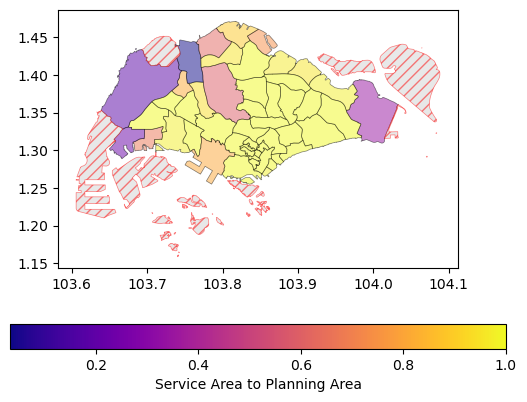

In [99]:
# map service area values SA_PA_ratio to planning area and add as a column to the planning area gdf
planningArea_shp.merge(serviceArea_df, how="left", left_on="PLN_AREA_N", right_on="PLN_AREA_N").plot(column="SA_PA_ratio", cmap="plasma", legend=True, edgecolor="black", linewidth=0.5, alpha=0.5,
                                                                                                     missing_kwds={
                                                                                                        "color": "lightgrey",
                                                                                                        "edgecolor": "red",
                                                                                                        "hatch": "///",
                                                                                                        "label": "Missing values",
                                                                                                    },
                                                                                                    legend_kwds={"label": "Service Area to Planning Area", "orientation": "horizontal"},)


### Plot travel time

<Axes: >

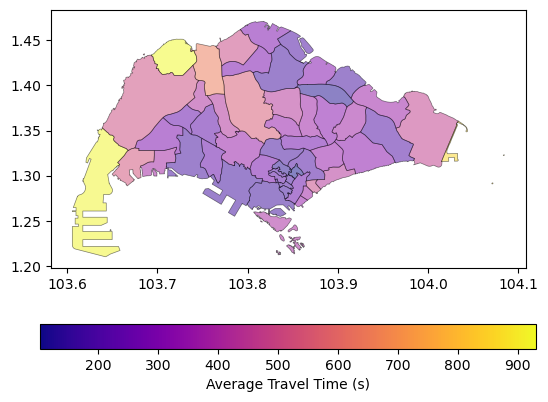

In [101]:
# map minimum travel time (min_travel_time) to planning area and add as a column to the planning area gdf
planningArea_shp.merge(planningArea_travelTimesHospital, how="inner", left_on="PLN_AREA_N", right_on="PLN_AREA_N").plot(column="min_travel_time", cmap="plasma", legend=True, edgecolor="black", linewidth=0.5, alpha=0.5,
                                                                                                     missing_kwds={
                                                                                                        "color": "lightgrey",
                                                                                                        "edgecolor": "red",
                                                                                                        "hatch": "///",
                                                                                                        "label": "Missing values",
                                                                                                    },
                                                                                                    legend_kwds={"label": "Average Travel Time (s)", "orientation": "horizontal"},)